### Module import

In [5]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

### Load image

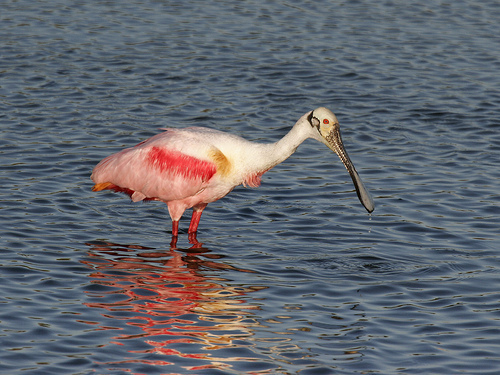

In [6]:
img_dir = 'images'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
img_name = 'water-bird.JPEG'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

### Load torchvision models and make model dictionaries

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval(), alexnet.cuda();

vgg = models.vgg16(pretrained=True)
vgg.eval(), vgg.cuda();

resnet = models.resnet101(pretrained=True)
resnet.eval(), resnet.cuda();

densenet = models.densenet161(pretrained=True)
densenet.eval(), densenet.cuda();

squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.eval(), squeezenet.cuda();


cam_dict = dict()

alexnet_model_dict = dict(type='alexnet', arch=alexnet, layer_name='features_11', input_size=(224, 224))
alexnet_gradcam = GradCAM(alexnet_model_dict, True)
alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

densenet_model_dict = dict(type='densenet', arch=densenet, layer_name='features_norm5', input_size=(224, 224))
densenet_gradcam = GradCAM(densenet_model_dict, True)
densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
squeezenet_gradcam = GradCAM(squeezenet_model_dict, True)
squeezenet_gradcampp = GradCAMpp(squeezenet_model_dict, True)
cam_dict['squeezenet'] = [squeezenet_gradcam, squeezenet_gradcampp]

### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [ ]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

### Save and show results 

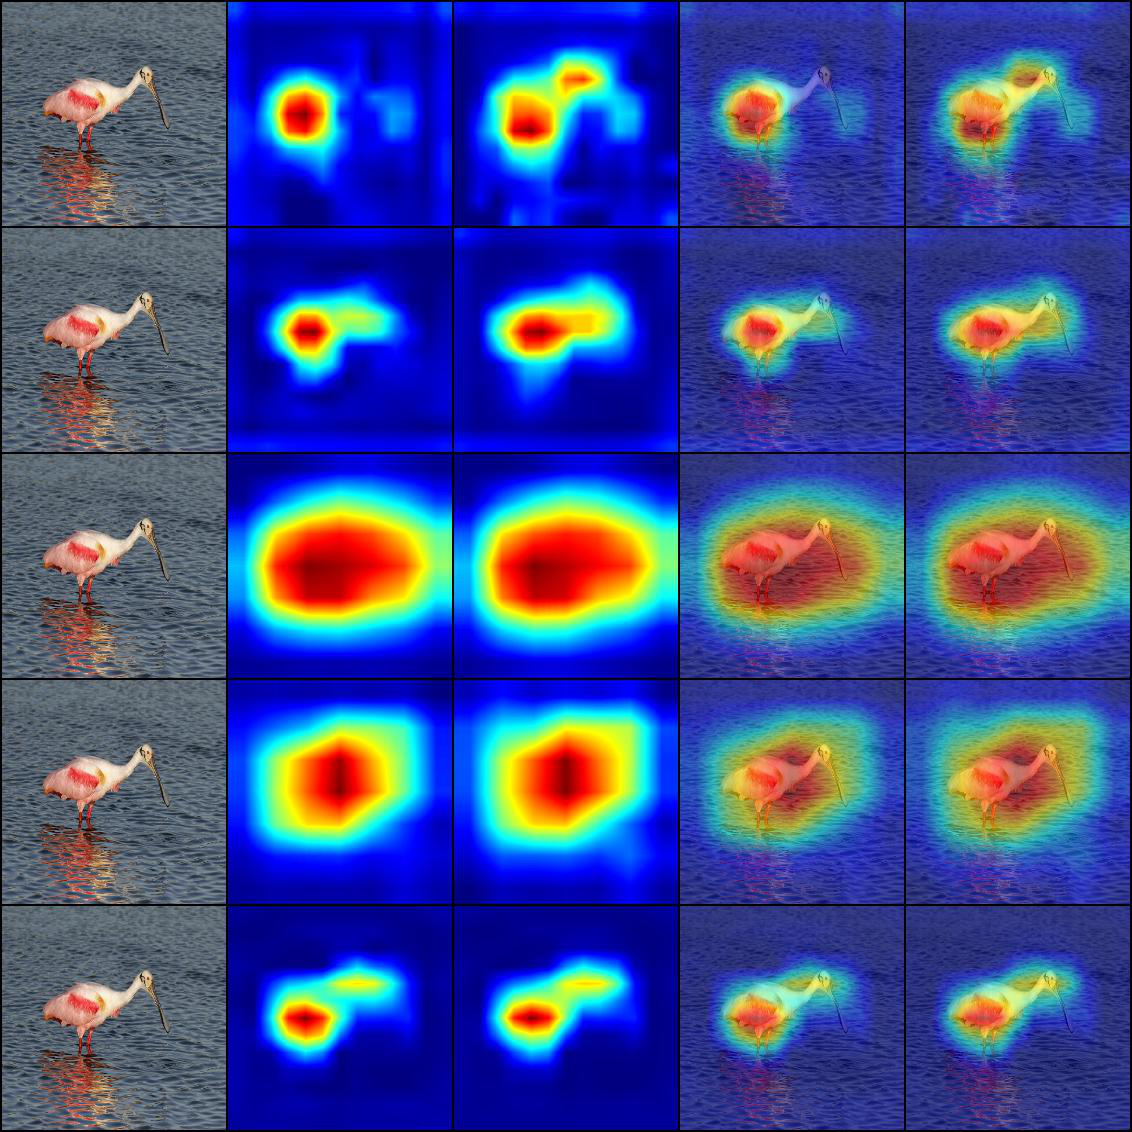

In [16]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)